In [34]:
%load_ext autoreload
%autoreload 2

from IPython.display import display

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull_amp as ppamp
import noise_models as noise

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:

def solve(push, verbose=False):

    if verbose:
        start = time.time()

    def cpp_loss(x, args):
        
#         print(x)

        (logalphaWS, logvWSp, logvbgp, Sigma2, A, B) = x
        (push) = args

        loss = push.loss(np.array([10**logalphaWS, 10**logvWSp, 10**logvbgp]), np.array([Sigma2, A, B]))

        return loss

    x0 = (3.0, 0.0, 0.0, 1.0, 1.0, 0.0)
    # x0 = (1.0, 1.0, 1e-3)
    bounds = [(None, None), (None, None), (-1.0, None), (1e-6, None), (0.0, None), (-1e-6, 1e-6)]

    if verbose:
        print("Initial Loss:", cpp_loss(x0, (push)))


    res = opt.minimize(cpp_loss, x0, args=(push,), method='L-BFGS-B', jac='2-point', bounds=bounds, 
                       options={'iprint':101, 'eps': 1e-8, 'gtol': 1e-8, 'ftol':1e-12})
    

    params = 10**res.x[:3]
    noise_params = res.x[3:]

    if verbose:
        print("Final Loss:", res.fun)

        end = time.time()

        print("Time Elapsed", end-start, "seconds")

        print(res)
                
        hess = la.inv(res.hess_inv.todense())
        
        evals, evecs = la.eigh(hess)
        
        param_labels = [r"$\log_{10}(\alpha_{WS})$", r"$\log_{10}(v_{WS}^p)$", r"$\log_{10}(v_{bg}^p)$", r"$\Sigma^2$", r"$A$", r"$B$"]
        
        s_list = []
        for i, labeli in enumerate(param_labels):
            for j, labelj in enumerate(param_labels):
                s_list.append([labeli, labelj, np.log10(np.abs(hess[i, j]))])
        
        df = pd.DataFrame(s_list, columns=['param1', 'param2', 'hess'])
        sns.heatmap(df.pivot("param1", "param2", "hess"), cbar_kws={'label': r"$\log_{10}(|H_{ij}|)$"}, cmap='cividis', center=0)
        
        plt.show()
        
        print(evals)
        
        s_list = []
        for i, labeli in enumerate(param_labels):
            for j in range(len(evals)):
                s_list.append([labeli, j, evecs[i, j]])
        
        df = pd.DataFrame(s_list, columns=['param1', 'eigenvector', 'val'])
        sns.heatmap(df.pivot("param1", "eigenvector", "val"), cmap='RdBu', center=0)
        
        plt.show()
        
    
    return noise_params, params

# Synthetic Data

## Generate Data

In [71]:
alphaWS, kWSp, kbgp, kbgu = 1.5e3, 13.0, 1.0, 1.0

vWSp = kWSp/kbgu
vbgp = kbgp/kbgu

print("Parameters:")
print("alphaWS:", alphaWS, "vWSp:", vWSp, "vbgp:", vbgp)

n_samples = 10000

print("Writer:")
WT_noise = noise.LogNormNoiseModel(mean=np.array([2.5, 4.0]), cov=np.array([[0.3, 0.35], [0.35, 0.5]]))
print("Substrate:")
ST_noise = noise.LogNormNoiseModel(mean=np.array([2.8, 4.0]), cov=np.array([[0.3, 0.25], [0.25, 0.3]]))

WT_anti = 10**np.random.normal(2.0, 0.5, size=n_samples)
ST_anti = 10**np.random.normal(2.8, 0.3, size=n_samples)

WT_GFP = WT_noise.anti_to_GFP(WT_anti)
ST_GFP = ST_noise.anti_to_GFP(ST_anti)

push = ppamp.Push()
 
SpT_GFP = push.predict_all(WT_GFP, ST_GFP, np.array([alphaWS, vWSp, vbgp]))

Sigma2 = 0.045
A = 0.7
B = 0.0

print(Sigma2, A, B)
    
SpT_anti = 10**np.random.normal(A*np.log10(SpT_GFP)+B, np.sqrt(Sigma2))

df_syn = pd.DataFrame(np.c_[WT_anti, ST_anti, WT_GFP, ST_GFP, SpT_GFP, SpT_anti], columns=['WT_anti', 'ST_anti', 'WT_GFP', 'ST_GFP', 'SpT_GFP', 'SpT_anti'])

df_syn['SpT_GFP/ST_GFP'] = df_syn['SpT_GFP'] / df_syn['ST_GFP']
df_syn['SpT_anti/ST_anti'] = df_syn['SpT_anti'] / df_syn['ST_anti']

display(df_syn)

Parameters:
alphaWS: 1500.0 vWSp: 13.0 vbgp: 1.0
Writer:
Antibody Noise Model: Sigma^2 0.03 A 0.54 B 0.33
GFP Noise Model: Sigma^2 0.05 A 1.51 B 0.23
Substrate:
Antibody Noise Model: Sigma^2 0.05 A 0.83 B -0.53
GFP Noise Model: Sigma^2 0.05 A 0.83 B 1.67
0.045 0.7 0.0


,WT_anti,ST_anti,WT_GFP,ST_GFP,SpT_GFP,SpT_anti,SpT_GFP/ST_GFP,SpT_anti/ST_anti
0,316.717441,440.975570,13532.215185,23155.780661,20494.579465,1346.932188,0.885074,3.054437
1,39.513114,646.867872,501.997954,23355.249247,13031.270438,798.989258,0.557959,1.235166
2,45.787304,1707.248736,330.028219,29396.149934,15651.869028,913.499026,0.532446,0.535071
3,723.542376,1058.373067,83116.206113,4787.632181,4463.178956,366.398816,0.932231,0.346191
4,614.652213,374.743344,16905.682158,21578.605427,19520.751762,684.018563,0.904635,1.825299
...,...,...,...,...,...,...,...,...
9995,52.527209,939.767822,1432.569332,10566.346731,7563.223445,389.517910,0.715784,0.414483
9996,30.362190,728.603864,254.990561,6881.379720,4006.122089,182.149522,0.582168,0.249998
9997,107.739380,588.765809,2427.570777,5852.104082,4867.290724,152.839748,0.831716,0.259593
9998,44.081255,459.678707,200.970506,9858.979610,5436.841817,569.185653,0.551461,1.238225


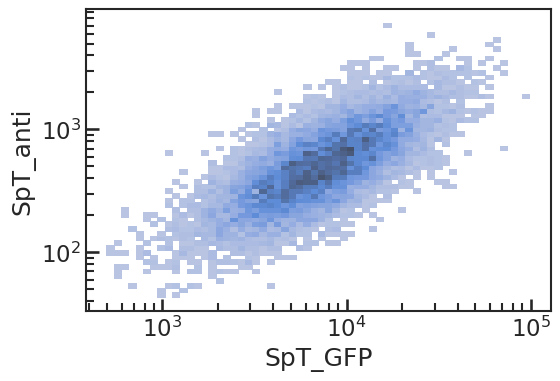

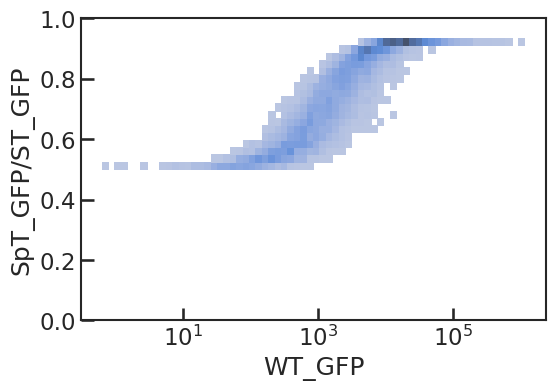

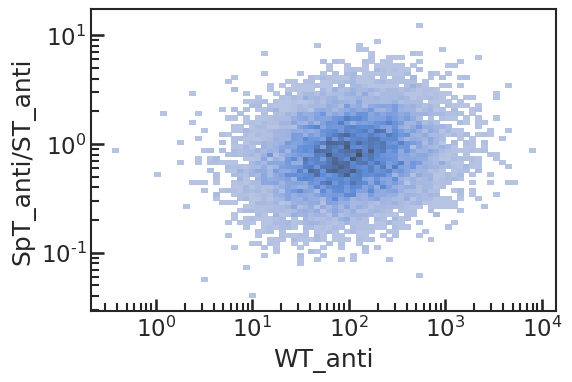

In [72]:
sns.histplot(df_syn, x='SpT_GFP', y='SpT_anti', log_scale=(True, True))

plt.show()


ax = sns.histplot(df_syn, x='WT_GFP', y='SpT_GFP/ST_GFP', log_scale=(True, False))
ax.set_ylim(0, 1.0)

plt.show()


ax = sns.histplot(df_syn, x='WT_anti', y='SpT_anti/ST_anti', log_scale=(True, True))

plt.show()

## Fit Model

Initial Loss: 0.573175010370304
Final Loss: -1.0555037788243378
Time Elapsed 1.3468689918518066 seconds
      fun: -1.0555037788243378
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.36875159e-08, -2.05415945e-07, -1.93715096e-07,  6.63101673e-06,
       -7.89761543e-06,  5.25504351e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 581
      nit: 66
     njev: 83
   status: 0
  success: True
        x: array([ 3.20502884e+00,  1.16066248e+00, -7.14210593e-03,  4.45560589e-02,
        6.99294686e-01, -1.00000000e-06])


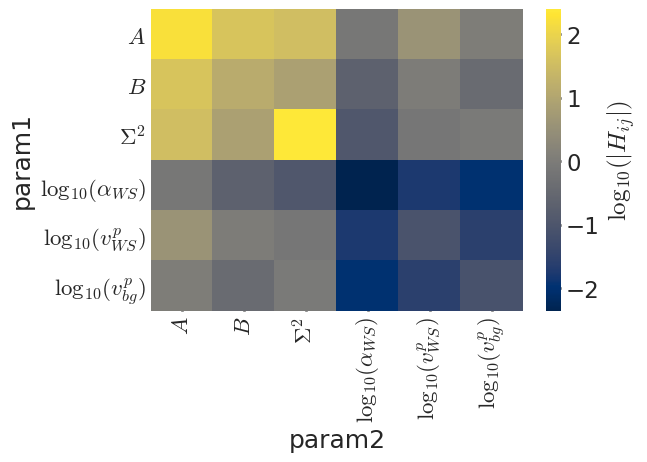

[5.64257031e-04 6.82329974e-03 6.53752485e-02 1.05124798e+00
 1.70718746e+02 2.63658419e+02]


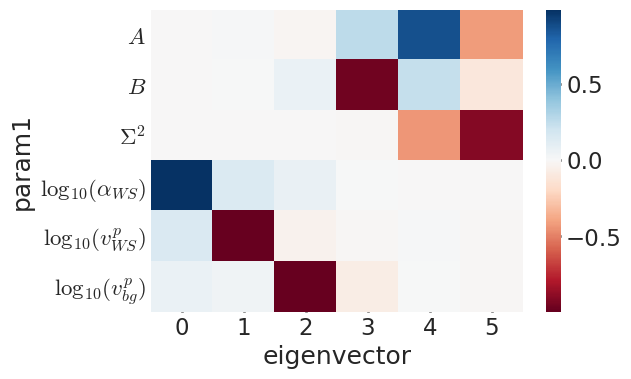

Fit values: 1603.3518730096096 14.47646344558648 0.9836891791722737 0.044556058855897585 0.6992946858544055 -1e-06
True values: 1500.0 13.0 1.0 0.045 0.7 0.0


In [73]:
push = ppamp.Push()
push.set_data(df_syn['WT_GFP'].values.copy(), df_syn['ST_GFP'].values.copy(), df_syn['SpT_anti'].values.copy())

noise_params, params = solve(push, verbose=True)

print("Fit values:", *params, *noise_params)
print("True values:", alphaWS, vWSp, vbgp, Sigma2, A, B)

## Plot Results

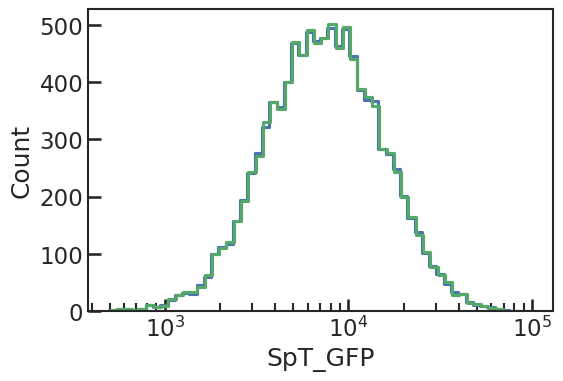

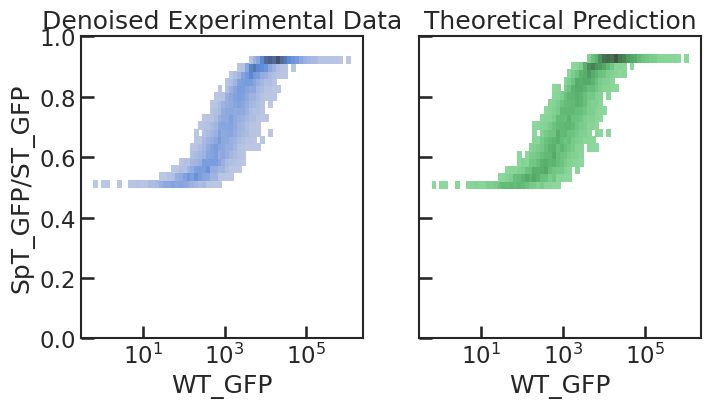

In [74]:
df_syn['SpT_GFP_predict'] = push.predict_all(params)
# df_syn['SpT_predict'] = push.predict_all(np.array([1300.0, 3333.3333333333335, 0.3333333333333333, 0.045, 0.7, 0.0]))

df_syn['SpT_GFP_predict/ST_GFP'] = df_syn['SpT_GFP_predict'] / df_syn['ST_GFP']


ax = sns.histplot(df_syn, x='SpT_GFP', log_scale=True, element="step", fill=False, label="True Values")
sns.histplot(df_syn, x='SpT_GFP_predict', log_scale=True, ax=ax, color='g', element="step", fill=False, label="Predicted Values")
plt.show()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

sns.histplot(df_syn, x='WT_GFP', y='SpT_GFP/ST_GFP', log_scale=(True, False), ax=ax1)
sns.histplot(df_syn, x='WT_GFP', y='SpT_GFP_predict/ST_GFP', log_scale=(True, False), color='g', ax=ax2)

ax1.set_ylim(0, 1.0)

ax1.set_title("Denoised Experimental Data")
ax2.set_title("Theoretical Prediction")

plt.show()



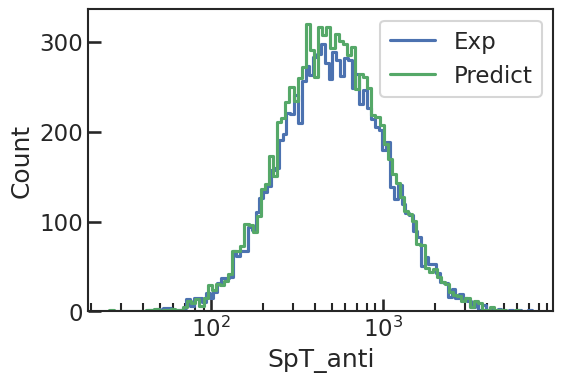

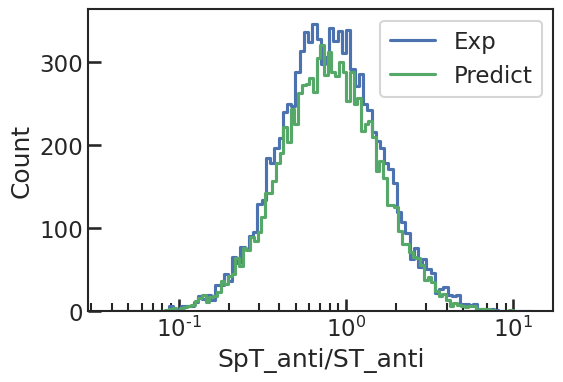

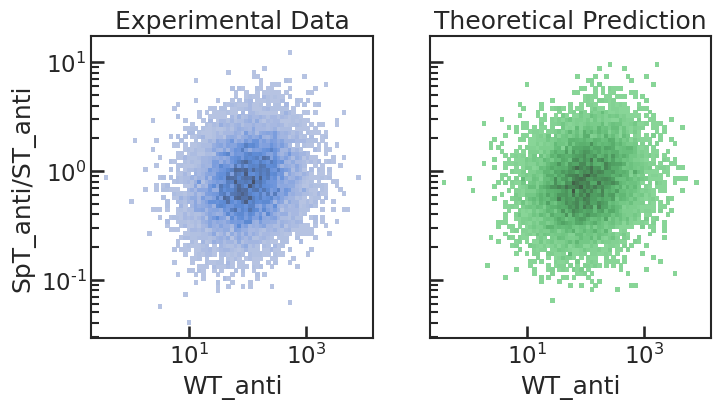

In [75]:
rand.seed(0)

(Sigma2, A, B) = noise_params

SpT_noise = noise.LogNormNoiseModel(Sigma2=noise_params[0], A=noise_params[1], B=noise_params[2])

df_syn['SpT_anti_predict'] = SpT_noise.GFP_to_anti(df_syn['SpT_GFP_predict'])

# 10**np.random.normal(A*np.log10(df_syn['SpT_GFP_predict'])+B, np.sqrt(Sigma2))

df_syn['SpT_anti_predict/ST_anti'] = df_syn['SpT_anti_predict'] / df_syn['ST_anti']


ax = sns.histplot(df_syn, x='SpT_anti', log_scale=True, element="step", fill=False, bins=100, label="Exp")
sns.histplot(df_syn, x='SpT_anti_predict', log_scale=True, ax=ax, color='g', element="step", fill=False, bins=100, label="Predict")

ax.legend()
plt.show()


ax = sns.histplot(df_syn, x='SpT_anti/ST_anti', log_scale=True, element="step", fill=False, bins=100, label="Exp")
sns.histplot(df_syn, x='SpT_anti_predict/ST_anti', log_scale=True, ax=ax, color='g', element="step", fill=False, bins=100, label="Predict")

ax.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

sns.histplot(df_syn, x='WT_anti', y='SpT_anti/ST_anti', log_scale=(True, True), ax=ax1)
sns.histplot(df_syn, x='WT_anti', y='SpT_anti_predict/ST_anti', log_scale=(True, True), color='g', ax=ax2)

ax1.set_title("Experimental Data")
ax2.set_title("Theoretical Prediction")


plt.show()



